In [1]:
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt

# =====================================================
# Helper functions
# =====================================================

def delta_phi(phi1, phi2):
    dphi = abs(phi1 - phi2)
    if dphi > 2*np.pi:
        dphi = 2*np.pi - dphi 
    return dphi

def delta_r(eta1, phi1, eta2, phi2):
    return np.sqrt((eta1 - eta2)**2 + delta_phi(phi1, phi2)**2)

def build_p4(pt, eta, phi):
    px = pt * np.cos(phi)
    py = pt * np.sin(phi)
    pz = pt * np.sinh(eta)
    e  = np.sqrt(px**2 + py**2 + pz**2)
    return px, py, pz, e

# =====================================================
# Read Delphes ROOT file
# =====================================================

file = uproot.open("X_prod.root")
tree = file["Delphes"]

jets = tree.arrays(
    ["Jet.PT", "Jet.Eta", "Jet.Phi", "Jet.BTag"],
    library="ak"
)

# =====================================================
# Jet quality cuts (reduce ISR/FSR)
# =====================================================

jets = jets[
    (jets["Jet.PT"] > 30.0) &
    (abs(jets["Jet.Eta"]) < 2.5)
]

# =====================================================
# Separate b-jets and light jets
# =====================================================

bjets     = jets[jets["Jet.BTag"] > 0.5]
lightjets = jets[jets["Jet.BTag"] <= 0.5]

# =====================================================
# Event selection: hadronic top topology
# (THIS IS THE CORRECT ak.num USAGE)
# =====================================================

mask = (
    (ak.num(bjets["Jet.PT"]) >= 1) &
    (ak.num(lightjets["Jet.PT"]) >= 2)
)

bjets     = bjets[mask]
lightjets = lightjets[mask]

# =====================================================
# Reconstruct W → jj from light jets
# =====================================================

pairs = ak.combinations(
    ak.zip({
        "pt":  lightjets["Jet.PT"],
        "eta": lightjets["Jet.Eta"],
        "phi": lightjets["Jet.Phi"]
    }),
    2
)

j1 = pairs["0"]
j2 = pairs["1"]

px1, py1, pz1, e1 = build_p4(j1.pt, j1.eta, j1.phi)
px2, py2, pz2, e2 = build_p4(j2.pt, j2.eta, j2.phi)

pxW = px1 + px2
pyW = py1 + py2
pzW = pz1 + pz2
eW  = e1  + e2

mW = np.sqrt(np.maximum(eW**2 - pxW**2 - pyW**2 - pzW**2, 0))

# =====================================================
# W mass window (suppresses ISR jet pairs)
# =====================================================

Wmask = abs(mW - 80.4) < 15.0

pxW = pxW[Wmask]
pyW = pyW[Wmask]
pzW = pzW[Wmask]

etaW = np.arcsinh(pzW / np.sqrt(pxW**2 + pyW**2))
phiW = np.arctan2(pyW, pxW)

# =====================================================
# ΔR(W, b): use ak.cartesian (NO broadcasting bugs)
# =====================================================

pairs_Wb = ak.cartesian(
    {
        "W_eta": etaW,
        "W_phi": phiW,
        "b_eta": bjets["Jet.Eta"],
        "b_phi": bjets["Jet.Phi"]
    },
    axis=1
)
print(pairs_Wb["W_phi"])
dR_Wb_all = delta_r(
    pairs_Wb["W_eta"],
    pairs_Wb["W_phi"],
    pairs_Wb["b_eta"],
    pairs_Wb["b_phi"]
)

# Choose closest b-jet → same top
dR_Wb_min = ak.min(dR_Wb_all, axis=1)

# Flatten for plotting
dR_flat = ak.to_numpy(dR_Wb_min)

# =====================================================
# Plot
# =====================================================

plt.figure(figsize=(7,5))
plt.hist(
    dR_flat,
    bins=40,
    range=(0,4),
    histtype="step",
    linewidth=2
)
plt.xlabel(r"$\Delta R(W,b)$")
plt.ylabel("Events")
plt.title("ΔR(W, b)")
plt.ylim(bottom=0)
plt.grid(True)
plt.tight_layout()
plt.show()


[[2.12, 2.12, 2.12, 2.12, 2.12, 2.12, ..., 1.84, 1.84, 1.84, 1.84, 1.84], ...]


ValueError: the truth value of an array whose length is not 1 is ambiguous; use ak.any() or ak.all()

In [2]:
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt

# --------------------------------------------------
# Δφ and ΔR helper functions
# --------------------------------------------------
def delta_phi(phi1, phi2):
    dphi = abs(phi1 - phi2)
    if dphi > 2*np.pi:
        dphi = 2*np.pi - dphi 
    return dphi

def delta_r(eta1, phi1, eta2, phi2):
    return np.sqrt((eta1 - eta2)**2 + delta_phi(phi1, phi2)**2)

def inv_mass(pt1, eta1, phi1, pt2, eta2, phi2):
    px1 = pt1 * np.cos(phi1)
    py1 = pt1 * np.sin(phi1)
    pz1 = pt1 * np.sinh(eta1)
    e1  = np.sqrt(px1**2 + py1**2 + pz1**2)

    px2 = pt2 * np.cos(phi2)
    py2 = pt2 * np.sin(phi2)
    pz2 = pt2 * np.sinh(eta2)
    e2  = np.sqrt(px2**2 + py2**2 + pz2**2)

    e  = e1 + e2
    px = px1 + px2
    py = py1 + py2
    pz = pz1 + pz2

    return np.sqrt(np.maximum(e**2 - px**2 - py**2 - pz**2, 0))

# --------------------------------------------------
# Input file
# --------------------------------------------------
file = uproot.open("X_prod.root")
tree = file["Delphes"]

jets = tree.arrays(
    ["Jet.PT", "Jet.Eta", "Jet.Phi", "Jet.BTag"],
    library="ak"
)

# --------------------------------------------------
# Basic jet selection
# --------------------------------------------------
pt_cut  = 30
eta_cut = 2.5

mask = (jets["Jet.PT"] > pt_cut) & (abs(jets["Jet.Eta"]) < eta_cut)
jets = jets[mask]

# --------------------------------------------------
# Separate b-jets and light jets
# --------------------------------------------------
bjets     = jets[jets["Jet.BTag"] > 0.5]
lightjets = jets[jets["Jet.BTag"] <= 0.5]

# Require at least 1 b-jet and 2 light jets
event_mask = (ak.num(bjets["Jet.PT"]) >= 1) & (ak.num(lightjets["Jet.PT"]) >= 2)
bjets     = bjets[event_mask]
lightjets = lightjets[event_mask]

# --------------------------------------------------
# Build W → jj candidates (light jets only)
# --------------------------------------------------
lj_pairs = ak.combinations(
    ak.zip({
        "pt":  lightjets["Jet.PT"],
        "eta": lightjets["Jet.Eta"],
        "phi": lightjets["Jet.Phi"]
    }),
    2
)

j1 = lj_pairs["0"]
j2 = lj_pairs["1"]

mjj = inv_mass(
    j1.pt, j1.eta, j1.phi,
    j2.pt, j2.eta, j2.phi
)

# W mass window
mW = 80.4
Wmask = abs(mjj - mW) < 15

j1W = j1[Wmask]
j2W = j2[Wmask]

# --------------------------------------------------
# ΔR between jets from W (from TOP)
# --------------------------------------------------
dR_Wjj = delta_r(
    j1W.eta, j1W.phi,
    j2W.eta, j2W.phi
)

dR_Wjj_flat = ak.to_numpy(ak.flatten(dR_Wjj))

# --------------------------------------------------
# Plot
# --------------------------------------------------
plt.figure(figsize=(7,5))
plt.hist(
    dR_Wjj_flat,
    bins=40,
    range=(0,4),
    histtype="step",
    linewidth=2
)
plt.xlabel(r"$\Delta R(j,j)$ from $W\to jj$ ")
plt.ylabel("Events")
plt.title("ΔR between jets")
plt.ylim(bottom=0)
plt.grid(True)
plt.tight_layout()
plt.show()


ValueError: the truth value of an array whose length is not 1 is ambiguous; use ak.any() or ak.all()

[[1.19, 1.19, 1.19, 1.19, 1.19, ..., 1.64, 1.64, -2.23, -2.23, -1.68], ...]


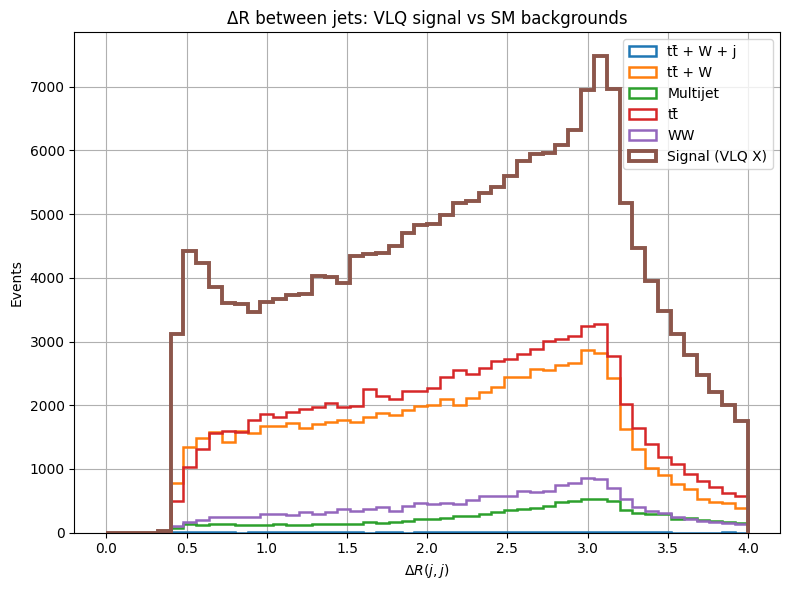

In [7]:
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt

# ==================================================
# Helper functions
# ==================================================
def delta_phi(phi1, phi2):
    return (phi1 - phi2 + np.pi) % (2*np.pi) - np.pi

def delta_r(eta1, phi1, eta2, phi2):
    return np.sqrt((eta1 - eta2)**2 + delta_phi(phi1, phi2)**2)

# ==================================================
# Compute ΔR(j,j) for a ROOT file
# ==================================================
def get_deltaR_jj(rootfile):
    tree = uproot.open(rootfile)["Delphes"]

    jets = tree.arrays(
        ["Jet.PT", "Jet.Eta", "Jet.Phi"],
        library="ak"
    )

    # Jet quality cuts (common to all samples)
    jets = jets[
        (jets["Jet.PT"] > 30) &
        (abs(jets["Jet.Eta"]) < 2.5)
    ]

    # Require ≥2 jets per event
    jets = jets[ak.num(jets["Jet.PT"]) >= 2]

    # All jet pairs
    pairs = ak.combinations(
        ak.zip({
            "eta": jets["Jet.Eta"],
            "phi": jets["Jet.Phi"]
        }),
        2
    )

    dR = delta_r(
        pairs["0"].eta,
        pairs["0"].phi,
        pairs["1"].eta,
        pairs["1"].phi
    )

    return ak.to_numpy(ak.flatten(dR))
print(pairs["0"].eta)
# ==================================================
# Input files
# ==================================================
signal_file = "/home/suprajaa/HEP_Softwares/MG5_aMC_v3_6_4/Delphes/X_prod.root"

bkg_files = {
    "tt̄ + W + j" : "/home/suprajaa/HEP_Softwares/MG5_aMC_v3_6_4/Delphes/pp2ttbwj.root",
    "tt̄ + W"     : "/home/suprajaa/HEP_Softwares/MG5_aMC_v3_6_4/Delphes/pp2ttbw.root",
    "Multijet"   : "/home/suprajaa/HEP_Softwares/MG5_aMC_v3_6_4/Delphes/multijet.root",
    "tt̄"        : "/home/suprajaa/HEP_Softwares/MG5_aMC_v3_6_4/Delphes/bg_ttbar.root",
    "WW"         : "/home/suprajaa/HEP_Softwares/MG5_aMC_v3_6_4/Delphes/bg_ww.root"
}

# ==================================================
# Compute ΔR distributions
# ==================================================
dR_signal = get_deltaR_jj(signal_file)

dR_bkgs = {}
for name, path in bkg_files.items():
    dR_bkgs[name] = get_deltaR_jj(path)

# ==================================================
# Plot
# ==================================================
plt.figure(figsize=(8,6))

# Backgrounds
for name, dR in dR_bkgs.items():
    plt.hist(
        dR,
        bins=50,
        range=(0,4),
        histtype="step",
        linewidth=1.8,
        label=name
    )

# Signal (draw last, thicker)
plt.hist(
    dR_signal,
    bins=50,
    range=(0,4),
    histtype="step",
    linewidth=2.8,
    label="Signal (VLQ X)"
)

plt.xlabel(r"$\Delta R(j,j)$")
plt.ylabel("Events")
plt.title("ΔR between jets: VLQ signal vs SM backgrounds")
plt.ylim(bottom=0)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


j1 wmask [[1.67, 2.89], [0.613], [], [], ..., [1.34], [2.19, 2.19], [3.07], [-1.02]]
inside func [[-2.23, -1.68], [-1.77], [], [], ..., [1.49], [-1.2, -1.2], [1.4], [-1.66]] [[-1.68, -2.14], [-1.21], [], [], ..., [0.749], [-0.523, -2.29], [1.6], [-2.22]] [[1.67, 2.89], [0.613], [], [], ..., [1.34], [2.19, 2.19], [3.07], [-1.02]] [[2.89, 0.617], [2.81], [], [], ..., [2.68], [-3.03, 1.6], [-1.39], [-0.692]]
j1 wmask [[0.898], [], [], [0.639, -1.41], [], ..., [1.88, ...], [2.19], [], [0.782], []]
inside func [[-2.49], [], [], [2.08, 2.15], [], [], ..., [...], [-2.4], [], [-0.388], []] [[-1.81], [], [], [1.2, 1.2], [], ..., [0.567, ...], [-2.47], [], [-0.241], []] [[0.898], [], [], [0.639, -1.41], [], ..., [1.88, ...], [2.19], [], [0.782], []] [[-0.316], [], [], [-0.305, -0.305], [], ..., [...], [1.57], [], [-0.366], []]
j1 wmask [[0.889], [], [2.71, -1.48], [], ..., [-2.61], [0.215], [2.85, 0.806, -2.5]]
inside func [[2.31], [], [-2.15, -1.77], [], ..., [-1.57], [0.144], [-0.899, 0.153, -

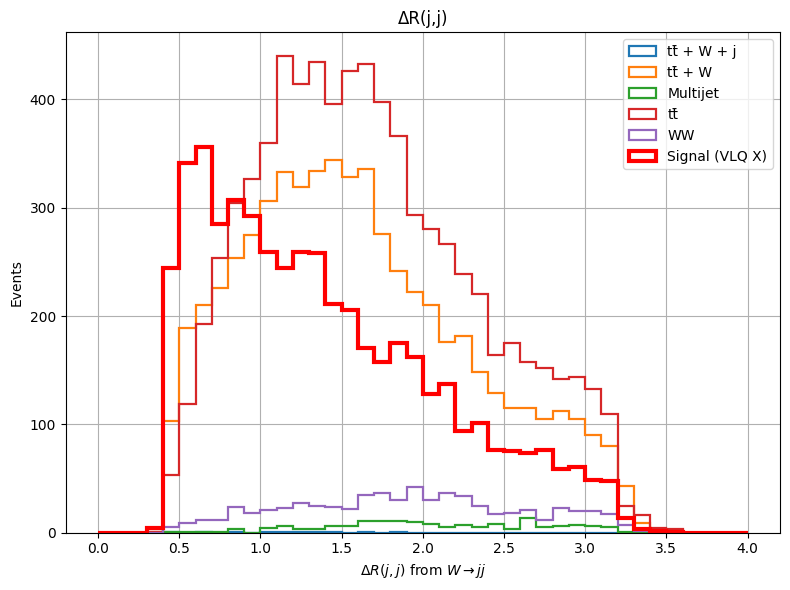

In [6]:
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt

# ==================================================
# Helper functions
# ==================================================
def delta_phi(phi1, phi2):
    return (phi1 - phi2 + np.pi) % (2*np.pi) - np.pi

def delta_r(eta1, phi1, eta2, phi2):
    print("inside func",eta1, eta2, phi1, phi2)
    return np.sqrt((eta1 - eta2)**2 + delta_phi(phi1, phi2)**2)

def build_p4(pt, eta, phi):
    px = pt * np.cos(phi)
    py = pt * np.sin(phi)
    pz = pt * np.sinh(eta)
    e  = np.sqrt(px**2 + py**2 + pz**2)
    return px, py, pz, e

# ==================================================
# Function: ΔR(j,j) from W → jj (ISR/FSR suppressed)
# ==================================================
def get_deltaR_Wjj(rootfile):
    tree = uproot.open(rootfile)["Delphes"]

    jets = tree.arrays(
        ["Jet.PT", "Jet.Eta", "Jet.Phi", "Jet.BTag"],
        library="ak"
    )

    # Jet quality cuts
    jets = jets[
        (jets["Jet.PT"] > 30) &
        (abs(jets["Jet.Eta"]) < 2.5)
    ]

    # Separate jets
    bjets     = jets[jets["Jet.BTag"] > 0.5]
    lightjets = jets[jets["Jet.BTag"] <= 0.5]

    # Hadronic top requirement
    mask = (
        (ak.num(bjets["Jet.PT"]) >= 1) &
        (ak.num(lightjets["Jet.PT"]) >= 2)
    )
    lightjets = lightjets[mask]

    # Build W → jj candidates
    pairs = ak.combinations(
        ak.zip({
            "pt":  lightjets["Jet.PT"],
            "eta": lightjets["Jet.Eta"],
            "phi": lightjets["Jet.Phi"]
        }),
        2
    )

    j1, j2 = pairs["0"], pairs["1"]

    px1, py1, pz1, e1 = build_p4(j1.pt, j1.eta, j1.phi)
    px2, py2, pz2, e2 = build_p4(j2.pt, j2.eta, j2.phi)

    mW = np.sqrt(
        np.maximum(
            (e1+e2)**2 - (px1+px2)**2 - (py1+py2)**2 - (pz1+pz2)**2,
            0
        )
    )

    # W mass window
    Wmask = abs(mW - 80.4) < 15
    print("j1 wmask",j1.phi[Wmask])
    
    dR = delta_r(
        j1.eta[Wmask],
        j1.phi[Wmask],
        j2.eta[Wmask],
        j2.phi[Wmask]
    )

    return ak.to_numpy(ak.flatten(dR))

# ==================================================
# Input files
# ==================================================
signal_file = "/home/suprajaa/HEP_Softwares/MG5_aMC_v3_6_4/Delphes/X_prod.root"

bkg_files = {
    "tt̄ + W + j" : "/home/suprajaa/HEP_Softwares/MG5_aMC_v3_6_4/Delphes/pp2ttbwj.root",
    "tt̄ + W"     : "/home/suprajaa/HEP_Softwares/MG5_aMC_v3_6_4/Delphes/pp2ttbw.root",
    "Multijet"   : "/home/suprajaa/HEP_Softwares/MG5_aMC_v3_6_4/Delphes/multijet.root",
    "tt̄"        : "/home/suprajaa/HEP_Softwares/MG5_aMC_v3_6_4/Delphes/bg_ttbar.root",
    "WW"         : "/home/suprajaa/HEP_Softwares/MG5_aMC_v3_6_4/Delphes/bg_ww.root"
}

# ==================================================
# Compute ΔR(j,j)
# ==================================================
dR_signal = get_deltaR_Wjj(signal_file)

dR_bkgs = {}
for name, path in bkg_files.items():
    dR_bkgs[name] = get_deltaR_Wjj(path)

# ==================================================
# Plot
# ==================================================
plt.figure(figsize=(8,6))

# Backgrounds
for name, dR in dR_bkgs.items():
    plt.hist(
        dR,
        bins=40,
        range=(0,4),
        histtype="step",
        linewidth=1.6,
        label=name
    )

# Signal in RED
plt.hist(
    dR_signal,
    bins=40,
    range=(0,4),
    histtype="step",
    linewidth=3.0,
    color="red",
    label="Signal (VLQ X)"
)

plt.xlabel(r"$\Delta R(j,j)$ from $W\to jj$")
plt.ylabel("Events")
plt.title("ΔR(j,j)")
plt.ylim(bottom=0)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("Delat R(j,j)", dpi=300)
plt.show()


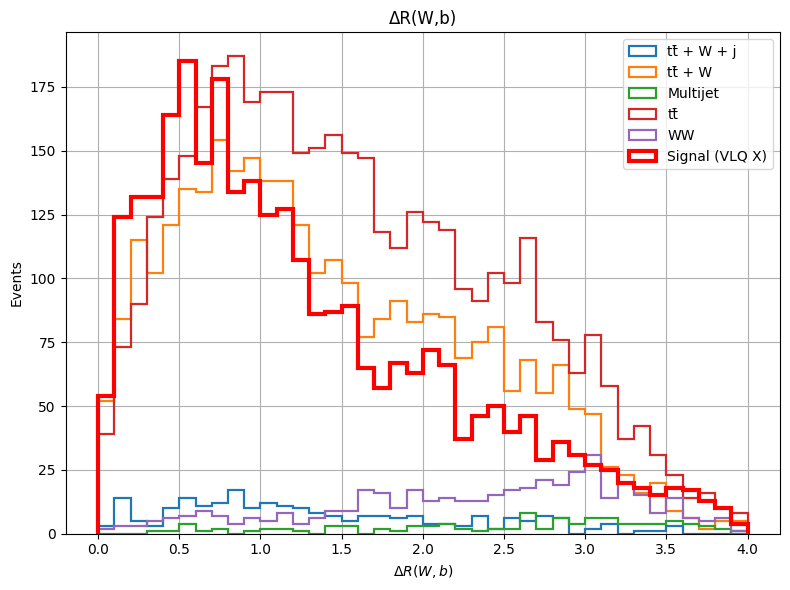

In [16]:
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt

# ==================================================
# Helper functions
# ==================================================
def delta_phi(phi1, phi2):
    return (phi1 - phi2 + np.pi) % (2*np.pi) - np.pi

def delta_r(eta1, phi1, eta2, phi2):
    return np.sqrt((eta1 - eta2)**2 + delta_phi(phi1, phi2)**2)

def build_p4(pt, eta, phi):
    px = pt * np.cos(phi)
    py = pt * np.sin(phi)
    pz = pt * np.sinh(eta)
    e  = np.sqrt(px**2 + py**2 + pz**2)
    return px, py, pz, e

# ==================================================
# Function: ΔR(W,b) from top decay (ISR/FSR suppressed)
# ==================================================
def get_deltaR_Wb(rootfile):
    tree = uproot.open(rootfile)["Delphes"]

    jets = tree.arrays(
        ["Jet.PT", "Jet.Eta", "Jet.Phi", "Jet.BTag"],
        library="ak"
    )

    # Jet quality cuts
    jets = jets[
        (jets["Jet.PT"] > 30) &
        (abs(jets["Jet.Eta"]) < 2.5)
    ]

    # Separate jets
    bjets     = jets[jets["Jet.BTag"] > 0.5]
    lightjets = jets[jets["Jet.BTag"] <= 0.5]

    # Hadronic top requirement
    mask = (
        (ak.num(bjets["Jet.PT"]) >= 1) &
        (ak.num(lightjets["Jet.PT"]) >= 2)
    )

    bjets     = bjets[mask]
    lightjets = lightjets[mask]

    # --------------------------------------------------
    # Reconstruct W → jj
    # --------------------------------------------------
    pairs = ak.combinations(
        ak.zip({
            "pt":  lightjets["Jet.PT"],
            "eta": lightjets["Jet.Eta"],
            "phi": lightjets["Jet.Phi"]
        }),
        2
    )

    j1, j2 = pairs["0"], pairs["1"]

    px1, py1, pz1, e1 = build_p4(j1.pt, j1.eta, j1.phi)
    px2, py2, pz2, e2 = build_p4(j2.pt, j2.eta, j2.phi)

    pxW = px1 + px2
    pyW = py1 + py2
    pzW = pz1 + pz2
    eW  = e1  + e2

    mW = np.sqrt(np.maximum(eW**2 - pxW**2 - pyW**2 - pzW**2, 0))

    # W mass window (KEY ISR/FSR suppression)
    Wmask = abs(mW - 80.4) < 15

    pxW = pxW[Wmask]
    pyW = pyW[Wmask]
    pzW = pzW[Wmask]

    etaW = np.arcsinh(pzW / np.sqrt(pxW**2 + pyW**2))
    phiW = np.arctan2(pyW, pxW)

    # --------------------------------------------------
    # ΔR(W,b): choose closest b-jet (same top)
    # --------------------------------------------------
    pairs_Wb = ak.cartesian(
        {
            "W_eta": etaW,
            "W_phi": phiW,
            "b_eta": bjets["Jet.Eta"],
            "b_phi": bjets["Jet.Phi"]
        },
        axis=1
    )

    dR_all = delta_r(
        pairs_Wb["W_eta"],
        pairs_Wb["W_phi"],
        pairs_Wb["b_eta"],
        pairs_Wb["b_phi"]
    )

    dR_min = ak.min(dR_all, axis=1)

    return ak.to_numpy(dR_min)

# ==================================================
# Input files
# ==================================================
signal_file = "/home/suprajaa/HEP_Softwares/MG5_aMC_v3_6_4/Delphes/X_prod.root"

bkg_files = {
    "tt̄ + W + j" : "/home/suprajaa/HEP_Softwares/MG5_aMC_v3_6_4/Delphes/pp2ttbwj.root",
    "tt̄ + W"     : "/home/suprajaa/HEP_Softwares/MG5_aMC_v3_6_4/Delphes/pp2ttbw.root",
    "Multijet"   : "/home/suprajaa/HEP_Softwares/MG5_aMC_v3_6_4/Delphes/multijet.root",
    "tt̄"        : "/home/suprajaa/HEP_Softwares/MG5_aMC_v3_6_4/Delphes/bg_ttbar.root",
    "WW"         : "/home/suprajaa/HEP_Softwares/MG5_aMC_v3_6_4/Delphes/bg_ww.root"
}

# ==================================================
# Compute ΔR(W,b)
# ==================================================
dR_signal = get_deltaR_Wb(signal_file)

dR_bkgs = {}
for name, path in bkg_files.items():
    dR_bkgs[name] = get_deltaR_Wb(path)

# ==================================================
# Plot
# ==================================================
plt.figure(figsize=(8,6))

# Backgrounds
for name, dR in dR_bkgs.items():
    plt.hist(
        dR,
        bins=40,
        range=(0,4),
        histtype="step",
        linewidth=1.6,
        label=name
    )

# Signal in RED
plt.hist(
    dR_signal,
    bins=40,
    range=(0,4),
    histtype="step",
    linewidth=3.0,
    color="red",
    label="Signal (VLQ X)"
)

plt.xlabel(r"$\Delta R(W,b)$")
plt.ylabel("Events")
plt.title("ΔR(W,b)")
plt.ylim(bottom=0)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("Delat R(w,b)", dpi=300)
plt.show()
